In [1]:
import os
import random
import requests
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText,  CoherenceModel
import numpy as np
import spacy
import string
from wordcloud import WordCloud
import unicodedata
import matplotlib.pyplot as plt
from nltk.util import ngrams
from collections import defaultdict, Counter
import itertools

In [2]:
# Fetch stopwords
def fetch_stopwords_from_github(url):
    response = requests.get(url)
    return set(response.text.splitlines())

github_stopwords_url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt'
github_stopwords = fetch_stopwords_from_github(github_stopwords_url)

stop_words = set(stopwords.words('english'))
custom_stop_words = ['like', 'yeah', 'know', 'um', 'uh', 'really', 'one', 'go', 'right', 'okay', 'well', 'said', 
                    'going', 'got', 'na', 'always', 'every', 'each', 'say', 'el', 'little', 'still', 
                    'best', 'dutch', 'nice', 'great', 'awesome', 'good', 'cool', 'love', 'amazing', 'wow',
                    'breaking news', 'report', 'coverage', 'investigation', 'interview', 'documentary', 'news', 'netherlands', 'psy', 'subtitle', 'description', 'link', 
                    'journalist', 'headline', 'reporter', 'current events', 'special report', 
                    'analysis', 'documented', 'broadcast', 'reporting', 'v', 'food', 'travel', 'react', 
                    'reacts', 'reaction', 'foreigner', 'thing', 'visit', 'dc', 'japan', 'first', 'fast', 
                    'asia', 'ang', 'indian', 'thai', 'vietnamese', 'russia', 'gon', 'canada', 'canadian', 'russian', 
                    'russia', 'guy', 'lot', 'bit', 'diba', 'ola', 'cuz', 'thai', 'thailand', 'person', 'citizen', 'foreigner', 'foreign', 'foreigners',
                    'facebook', 'filipinos', 'filipinas', 'vlog', 'vlogs', 'vlogging', 'hashtag', 'india', 'bro', 'dito', 'people', 'time', 'music', 'gonna', 'life', 
                    'lol', 'guys', 'tho', 'cute', 'hmm', 'huh', 'channel', 'subscribe', 'day6', 'mandarin', 'chinese', 'beautiful',
                    'chuckles', 'fbe', 'hit', 'laughs', 'yo', 'ka', 'word', 'living', 'boi', 'minimum', 'ya', 'successful', 'perfectly', 'yeap', 
                    'wondering', 'fantastic', 'hurry', 'german', 'age', 'country', 'subscribing', 'bluesy', 'jump', 'pretty', 'understanding', 'personalized',
                    'and', 'the', 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'up', 'about', 'over', 'into', 'through', 'between', 'under', 'against', 'all',
                    'you', 'haha', 'hahaha', 'ha', 'hey', 'bye', 'hello', 'hi', 'oh', 'blah', 'easy', 'alright', 'ta', 'day', 'ooh', 'en', 'do', 'lot', 'comment', 'notification', 
                    'korean', 'jjajangmyeon', 'jajangmyeon', 'damn', 'yall', 'month', 'week', 'year', 'ohhh', 'pvf', 'dude', 'mmm', 'kagilagilalas', 'ofcourse', 'australia', 'uxo', 
                    'atleast', 'yusuf', 'bangkok', 'ot', 'anytime', 'allover', 'kala', 'nope', 'wan', 'brazil', 'smooth', 'ot', 'timeshere', 'batchof', 'yep', 'opo', 'del',
                    'gosh', 'po', 'ourself', 'wo', 'wait', 'ugh', 'nyc', 'whoa', 'nicaragua', 'yup', 'em', 'bout', 'le', 'omg', 'overwhelm', 'maam', 'nicer', 'haha', 'hahaha', 'ha', 
                    'nbcs', 'lana', 'rc', 'whatsoever', 'oxy', 'decade', 'whyd', 'unknown', 'ahhhhh', 'ohoh', 'ohto', 'ohhhh', 'bruh', 'ooe', 'ahmedabad', 'mexico', 
                    'understand', 'excuse', 'kinda', 'applause', 'oooh', 'thiswhat', 'nevermind', 'ahh', 'againthank', 'toto', 'aww', 'nah', 'bbmas', 'ay', 'op', 'huh', 'huhu',
                    'tada', 'beacuse', 'voila', 'upstairs', 'thatswhy', 'yea', 'that', 'armenia', 'or', 'not', 'funwhat', 'aka', 'armeniathat', 'woosexy', 'worth', 'laugh', 'box', 
                    'xd', 'vb', 'eff', 'ananya', 'welsh', 'latron', 'shout', 'whatwhat', 'what', 'pause', 'why', 'thats', 'byebye', 'iv', 'bye', 'ado', 'ownup', 'dom', 'jomm', 'sir', 
                    'budgie', 'nomac', 'lavocha', 'germany', 'why', 'walang', 'superduper', 'philip', 'mom', 'jre', 'giddy', 'intro', 'dupe', 'europe', 'dream', 'team', 'dislike', 'content', 
                    'yoongi', 'royale', 'ilu', 'jhope', 'day', 'jin', 'ecc', 'nyhs', 'nego', 'chavez', 'pb', 'everyones', 'epic', 'matter', 'oneonone', 'region', 'change', 'ho', 'seetoh', 
                    'atin', 'vpn', 'facetune', 'busu', 'mackie', 'clyd', 'china', 'rest', 'friend', 'woah', 'dindins', 'poster', 'vibe', 'woman', 'boss', 'woah', 'type', 'mahana', 'joke', 
                    'taller', 'insane', 'whang', 'psa', 'manatee', 'recommend', 'caesar', 'mmmhmm', 'mosul', 'dun', 'clue', 'naysayer', 'hindi', 'ko', 'pero', 'bulgaria', 'question', 'video', 
                    'yobi', 'hindu', 'expat', 'option', 'gap', 'eu', 'simo', 'kouignamann', 'bct', 'month', 'cfo', 'philippines', 'philippine', 'british', 'filipino', 'video', 
                    'http', 'korea', 'korean', 'youtube', 'google', 'united', 'america', 'american', 'kpop', '필리핀', 'bts', 'blackpink', 'twice', 'exo', 'k-pop', 
                    'seventeen', 'stray kids', 'nct', 'kdrama', 'aespa', 'taehyung', 'jimin', 'jungkook']
stop_words.update(custom_stop_words, github_stopwords)

lemmatizer = WordNetLemmatizer()

In [3]:
# Helper function to check if a word contains only Latin script characters
def is_latin_script(word):
    for char in word:
        if not ('LATIN' in unicodedata.name(char, '') or char.isdigit()):
            return False
    return True

def preprocess_text(doc, video_id, ngram_range=(1, 2), tag_weight=1, ngram_weight_factor=1):
    doc = doc.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(doc)
    tokens_with_pos = pos_tag(tokens)

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tokens_with_pos]

    # Generate n-grams
    ngram_tokens = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngram_tokens.extend([' '.join(gram) for gram in ngrams(lemmatized_tokens, n)])

    # Count n-gram frequency
    ngram_frequencies = Counter(ngram_tokens)

    # Filter stopwords and non-useful words
    filtered_tokens = []
    for word, pos in tokens_with_pos:
        if not word.isalpha() or word in stop_words:
            continue
        if pos in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']:
            continue  # Remove verbs and adjectives
        filtered_tokens.append(word)

    # Assign weight based on n-grams 
    weighted_tokens = []
    for token in filtered_tokens:
        token_weight = 1 + ngram_frequencies.get(token, 0) * ngram_weight_factor
        weighted_tokens.extend([token] * int(token_weight))

    # Include video tags
    if video_id in video_tags:
        tags = video_tags[video_id]
        for tag in tags:
            if tag.isalpha():
                tag_weight_multiplier = tag_weight
                weighted_tokens.extend([tag] * int(tag_weight_multiplier))
    return ' '.join(weighted_tokens)

def get_wordnet_pos(treebank_tag):
    """Convert POS tag to WordNet format for lemmatization."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
# Folder paths
transcripts_folder_path = 'standard_dataset/'
tags_folder_path = 'tags/'

# Function to load video tags only for fetched video IDs
def load_video_tags(folder_path, video_ids):
    video_tags = {}
    for video_id in video_ids:
        tag_file = os.path.join(folder_path, f"{video_id}.txt")
        if os.path.exists(tag_file):
            with open(tag_file, "r", encoding="utf-8") as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()  # Store as list of words
        else:
            video_tags[video_id] = []  # Default to empty list if no tags
    return video_tags

video_ids = []
transcript_files = []
for file_name in os.listdir(transcripts_folder_path):
    if file_name.endswith('.txt'):
        video_id = file_name.split('_captions')[0]
        video_ids.append(video_id)
        transcript_files.append((video_id, file_name)) 

video_tags = load_video_tags(tags_folder_path, video_ids)

all_documents = []
for video_id, file_name in transcript_files:
    with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
        content = file.read().lower()
        if len(content.split()) >= 100: 
            processed_text = preprocess_text(content, video_id)  
            all_documents.append(processed_text)

In [7]:
# Create Dictionary and Corpus for LDA
dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]

# Define parameter grid
num_topics_range = [3, 5, 7, 10] 
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1, 'auto']
eta_values = ['symmetric', 0.01, 0.1, 'auto']
passes_range = [20, 50, 100]  

best_model = None
best_coherence = -np.inf
best_params = {}

# Iterate over all combinations of parameters
for num_topics, alpha, eta, passes in itertools.product(num_topics_range, alpha_values, eta_values, passes_range):
    print(f"Training LDA with num_topics={num_topics}, alpha={alpha}, eta={eta}, passes={passes}")

    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, 
                         alpha=alpha, eta=eta, passes=passes)
    
    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    #coherence_model = CoherenceModel(model=lda_model, texts=[doc.split() for doc in all_documents], 
                                     #dictionary=dictionary, coherence='u_mass')
    coherence_score = coherence_model.get_coherence()
    
    print(f"Coherence Score: {coherence_score}")

    # Update best model if new coherence score is higher
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_model = lda_model
        best_params = {'num_topics': num_topics, 'alpha': alpha, 'eta': eta, 'passes': passes}

print("\nBest Model Parameters:", best_params)
print("Best Coherence Score:", best_coherence)


Training LDA with num_topics=3, alpha=symmetric, eta=symmetric, passes=20
Coherence Score: -4.4531691671771325
Training LDA with num_topics=3, alpha=symmetric, eta=symmetric, passes=50
Coherence Score: -3.56610003261569
Training LDA with num_topics=3, alpha=symmetric, eta=symmetric, passes=100
Coherence Score: -4.977421052217129
Training LDA with num_topics=3, alpha=symmetric, eta=0.01, passes=20
Coherence Score: -3.8706558055698537
Training LDA with num_topics=3, alpha=symmetric, eta=0.01, passes=50
Coherence Score: -4.83638430226359
Training LDA with num_topics=3, alpha=symmetric, eta=0.01, passes=100
Coherence Score: -3.5973623382658233
Training LDA with num_topics=3, alpha=symmetric, eta=0.1, passes=20
Coherence Score: -5.527797180933302
Training LDA with num_topics=3, alpha=symmetric, eta=0.1, passes=50
Coherence Score: -2.9589614132798587
Training LDA with num_topics=3, alpha=symmetric, eta=0.1, passes=100
Coherence Score: -3.263676082200632
Training LDA with num_topics=3, alpha=

In [15]:
# Create Dictionary and Corpus for LDA
dictionary = corpora.Dictionary([doc.split() for doc in all_documents])
corpus = [dictionary.doc2bow(doc.split()) for doc in all_documents]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, 
                        alpha='auto', eta='symmetric', passes=100)

# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score}")

Coherence Score: -3.417020237447145


In [17]:
for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    print(f"Video {video_id}: {topic_distribution}")


Video --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­: [(0, 8.680068e-06), (1, 0.99998766), (2, 3.6336571e-06)]
Video 0IMWasj76yU_Philippines Army vs Thailand Army: [(0, 0.00027755345), (1, 0.9996063), (2, 0.00011618906)]
Video 1kErCqgIVMk_Tour of The House We Built in The Philippines: [(0, 7.146426e-05), (1, 0.9998986), (2, 2.9916506e-05)]
Video 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY!: [(0, 0.7430324), (1, 4.6823356e-05), (2, 0.25692084)]
Video 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi: [(0, 0.99972785), (1, 0.0001793188), (2, 9.281939e-05)]
Video 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United: [(0, 0.39679798), (1, 0.60217977), (2, 0.0010222626)]
Video 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises: [(0, 7.82451e-05), (1, 6.327995e-05), (2, 0.9998585)]
Video 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­: [(0, 0.76213485), (1, 0.23772965), (2, 0.00013551496)]
Vid

In [18]:
topics = lda_model.print_topics(num_words=20) 
for topic_id, topic_words in topics:
    print(f"Topic {topic_id}: {topic_words}")


Topic 0: 0.055*"chicken" + 0.024*"damian" + 0.022*"sauce" + 0.020*"pizza" + 0.019*"pork" + 0.015*"restaurant" + 0.013*"rice" + 0.012*"egg" + 0.012*"brother" + 0.011*"father" + 0.010*"meat" + 0.009*"family" + 0.009*"rain" + 0.009*"taste" + 0.008*"soup" + 0.008*"dish" + 0.008*"spaghetti" + 0.008*"dessert" + 0.007*"nido" + 0.007*"bite"
Topic 1: 0.070*"beach" + 0.036*"island" + 0.033*"water" + 0.024*"rice" + 0.022*"roline" + 0.021*"hotel" + 0.018*"chef" + 0.018*"christmas" + 0.014*"hour" + 0.014*"lechon" + 0.011*"spot" + 0.009*"god" + 0.008*"jet" + 0.008*"money" + 0.007*"night" + 0.007*"fun" + 0.007*"couple" + 0.007*"coffee" + 0.006*"salty" + 0.006*"flavor"
Topic 2: 0.113*"baguio" + 0.035*"market" + 0.031*"stuff" + 0.028*"strawberry" + 0.026*"city" + 0.022*"manila" + 0.022*"view" + 0.022*"park" + 0.018*"dale" + 0.015*"cream" + 0.014*"mall" + 0.014*"ramen" + 0.013*"trail" + 0.013*"ride" + 0.010*"balcony" + 0.009*"hotel" + 0.008*"rice" + 0.008*"ice" + 0.008*"jeepney" + 0.008*"tshirt"


In [21]:
for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]  # Highest probability
    print(f"Video {video_id}: Dominant Topic {dominant_topic[0]} with probability {dominant_topic[1]:.4f}")


Video --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­: Dominant Topic 1 with probability 1.0000
Video 0IMWasj76yU_Philippines Army vs Thailand Army: Dominant Topic 1 with probability 0.9996
Video 1kErCqgIVMk_Tour of The House We Built in The Philippines: Dominant Topic 1 with probability 0.9999
Video 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY!: Dominant Topic 0 with probability 0.7430
Video 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi: Dominant Topic 0 with probability 0.9997
Video 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United: Dominant Topic 1 with probability 0.6022
Video 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises: Dominant Topic 2 with probability 0.9999
Video 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­: Dominant Topic 0 with probability 0.7621
Video 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!!: Dominant Topic 0 with probability 0.9991
Video 7j

In [22]:
from collections import defaultdict

# Dictionary to store the count of videos per topic
topic_video_count = defaultdict(int)

# Mapping of video ID to its dominant topic
video_topic_mapping = {}

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

    # Get the most dominant topic (highest probability)
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    
    # Store the mapping
    video_topic_mapping[video_id] = dominant_topic
    
    # Increase count for that topic
    topic_video_count[dominant_topic] += 1

# Print number of videos assigned to each topic
print("\nNumber of Videos per Topic:")
for topic, count in sorted(topic_video_count.items()):
    print(f"Topic {topic}: {count} videos")



Number of Videos per Topic:
Topic 0: 45 videos
Topic 1: 38 videos
Topic 2: 17 videos


In [ ]:
# Dictionary to store videos per topic (multiple topics per video allowed)
topic_to_videos = defaultdict(list)

# Mapping of video ID to its assigned topics
video_topic_mapping = {}

# Set a probability threshold for assigning multiple topics
prob_threshold = 0.2

for idx, doc_bow in enumerate(corpus):
    video_id = video_ids[idx]  # Get video ID
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0)

    # Get topics where probability is above threshold
    assigned_topics = [topic for topic, prob in topic_distribution if prob >= prob_threshold]

    # Store the mapping
    video_topic_mapping[video_id] = assigned_topics

    # Add video to each topic it belongs to
    for topic in assigned_topics:
        topic_to_videos[topic].append(video_id)

# Count occurrences of each topic
topic_counts = Counter()

for topics in video_topic_mapping.values():
    for topic in topics:
        topic_counts[topic] += 1

# Print the number of videos per topic
print("\nNumber of Videos Per Topic:")
for topic, count in sorted(topic_counts.items()):
    print(f"Topic {topic}: {count} videos")

# Print topics assigned per video
print("\nTopics Assigned Per Video:")
for video_id, topics in video_topic_mapping.items():
    topic_list = ', '.join(map(str, topics)) if topics else "No dominant topic"
    print(f"Video ID: {video_id} → Topics: {topic_list}")

# Print videos per topic
print("\nTop Words Per Topic:")
num_words = 30  

for topic_id in sorted(topic_to_videos.keys()): 
    top_words = lda_model.show_topic(topic_id, num_words)
    words_str = ', '.join([word for word, prob in top_words])
    print(f"Topic {topic_id}: {words_str}")



Number of Videos Per Topic:
Topic 0: 53 videos
Topic 1: 44 videos
Topic 2: 22 videos

Topics Assigned Per Video:
Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­ → Topics: 1
Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army → Topics: 1
Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines → Topics: 1
Video ID: 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY! → Topics: 0, 2
Video ID: 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi → Topics: 0
Video ID: 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United → Topics: 0, 1
Video ID: 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises → Topics: 2
Video ID: 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­ → Topics: 0, 1
Video ID: 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!! → Topics: 0
Video ID: 7jDrzdX2Ucc_Approve ba ako sa anak at mama ni misterðŸ¤”Mia Sandoval → Topics: 1
Video ID: 7zaMbzqj8AI_Rentin

In [ ]:
# Folder paths
transcripts_folder_path = 'standard_dataset/'
tags_folder_path = 'tags/'

# Load video tags
def load_video_tags(folder_path, video_ids):
    video_tags = {}
    for video_id in video_ids:
        tag_file = os.path.join(folder_path, f"{video_id}.txt")
        if os.path.exists(tag_file):
            with open(tag_file, "r", encoding="utf-8") as file:
                tags_content = file.read().lower()
                video_tags[video_id] = tags_content.split()  # Store as list of words
        else:
            video_tags[video_id] = []  # Default to empty list if no tags
    return video_tags

# Load transcripts
video_ids = []
transcript_files = []
for file_name in os.listdir(transcripts_folder_path):
    if file_name.endswith('.txt'):
        video_id = file_name.split('_captions')[0]
        video_ids.append(video_id)
        transcript_files.append((video_id, file_name)) 

video_tags = load_video_tags(tags_folder_path, video_ids)

video_topics = {}

for video_id, file_name in transcript_files:
    with open(os.path.join(transcripts_folder_path, file_name), 'r', encoding='utf-8') as file:
        content = file.read().lower()
        
        if len(content.split()) >= 100:  
            processed_text = preprocess_text(content, video_id)
            
            # Create Dictionary and Corpus
            tokens = processed_text.split()
            corpus = [dictionary.doc2bow(tokens)]
            
            # Train LDA Model
            num_topics = 3  # Limit topics to at most 5 or vocab size
            lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20, alpha='auto', eta='symmetric')
            
            # Compute Coherence Score
            coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
            coherence_score = coherence_model.get_coherence()
            
            # Get topic distribution for the video
            topic_distribution = lda_model.get_document_topics(corpus[0], minimum_probability=0)
            assigned_topics = {topic: prob for topic, prob in topic_distribution if prob > 0.5}  # Threshold for multiple topics
            
            # Store video topic info
            video_topics[video_id] = {
                "topics": assigned_topics,
                "top_words": {i: lda_model.show_topic(i, 20) for i in range(num_topics)},
                "coherence": coherence_score
            }

# Print topics per video
for video_id, data in video_topics.items():
    print(f"\nVideo ID: {video_id}")
    print(f"Coherence Score: {data['coherence']:.4f}")
    print("Assigned Topics:")
    for topic_id, prob in data["topics"].items():
        print(f"  Topic {topic_id} ({prob:.2f} probability): {[word for word, _ in data['top_words'][topic_id]]}")


Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­
Coherence Score: 0.0000
Assigned Topics:
  Topic 2 (1.00 probability): ['beach', 'hotel', 'water', 'jet', 'god', 'sand', 'tide', 'couple', 'fun', 'hour', 'pool', 'night', 'hat', 'power', 'ski', 'view', 'bed', 'yesterday', 'margarita', 'ocean']

Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army
Coherence Score: -9.3073
Assigned Topics:
  Topic 0 (1.00 probability): ['salt', 'sad', 'military', 'sea', 'power', 'ground', 'air', 'force', 'forces', 'helicopters', 'tank', 'troopers', 'naval', 'helicop', 'helicopt', 'tanks', 'motoribikes', 'massage', 'maths', 'motivation']

Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines
Coherence Score: 0.0000
Assigned Topics:
  Topic 0 (1.00 probability): ['water', 'house', 'floor', 'door', 'glass', 'steel', 'tile', 'grill', 'light', 'finish', 'sun', 'storage', 'stuff', 'tour', 'concrete', 'hand', 'cut', 'leak', 'bathroom', 'block']

Video ID: 2ftG8JuMzz4_Top

d:\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Cluster Statistics ===
Number of Videos Per Cluster:
Cluster 0: 23 videos
Cluster 1: 31 videos
Cluster 2: 10 videos
Cluster 3: 16 videos
Cluster 4: 20 videos

Video Cluster Assignments:
Video ID: --8n6A8Q6M0_$200 Luxury Beach Hotel in The Philippines ðŸ‡µðŸ‡­ → Clusters: 0
Video ID: 0IMWasj76yU_Philippines Army vs Thailand Army → Clusters: 1
Video ID: 1kErCqgIVMk_Tour of The House We Built in The Philippines → Clusters: 1
Video ID: 2ftG8JuMzz4_Top 5 Exotic Foods in the Philippines The BRAVE MUST TRY! → Clusters: 1
Video ID: 2TmagN6RhkI_VOCAL COACH REACTS - REGINE VELASQUEZ - Araw-Gabi → Clusters: 0
Video ID: 3n1nspLgfd4_Balut!!!!! - Manila, Philippines - Now United → Clusters: 2
Video ID: 401ZvQ11euA_Did China Buy the Philippines With False Investment Promises → Clusters: 0
Video ID: 4OiOwDh5lKE_Chef Kuya Joey Is Flying To The Philippines!  ðŸ‡µðŸ‡­ → Clusters: 3
Video ID: 6ftiWoCJ4dM_Filipino Food In The Netherlands  Cafe Nordrick!! → Clusters: 1
Video ID: 7jDrzdX2Ucc_Approve ba 

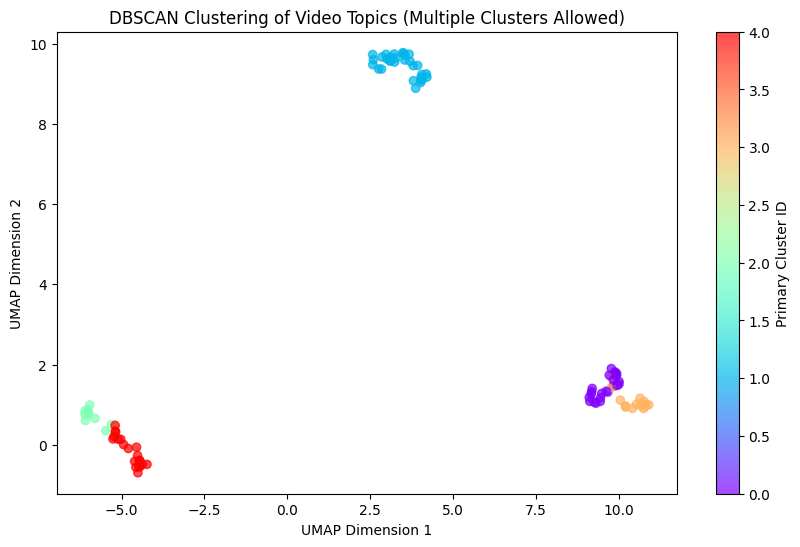

In [ ]:
import numpy as np
import umap
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: Create feature matrix (rows: videos, cols: topic probabilities)
video_ids_list = list(video_topics.keys())
num_topics = 3  

video_features = np.zeros((len(video_ids_list), num_topics))

for i, video_id in enumerate(video_ids_list):
    for topic_id, prob in video_topics[video_id]["topics"].items():
        video_features[i, topic_id] = prob  # Assign probability to correct topic index

# Step 2: Standardize the data
scaler = StandardScaler()
video_features_scaled = scaler.fit_transform(video_features)

# Step 3: Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=5, n_neighbors=30, min_dist=0.1, random_state=42)
video_embeddings = umap_model.fit_transform(video_features_scaled)

# Step 4: Cluster using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)  # Tune hyperparameters
clusters = dbscan.fit_predict(video_embeddings)

# Step 5: Assign Multiple Clusters Based on Distance to Centroids
unique_clusters = set(clusters) - {-1}  # Ignore noise (-1)
cluster_centroids = {cluster: np.mean(video_embeddings[clusters == cluster], axis=0) for cluster in unique_clusters}

video_clusters = defaultdict(list)

for i, video_id in enumerate(video_ids_list):
    video_point = video_embeddings[i]
    
    # Compute distance to each cluster centroid
    distances = {cluster: np.linalg.norm(video_point - centroid) for cluster, centroid in cluster_centroids.items()}
    
    # Assign primary cluster (closest centroid)
    primary_cluster = min(distances, key=distances.get)
    video_clusters[video_id].append(primary_cluster)
    
    # Assign additional clusters if they are within a reasonable threshold
    threshold = 0.2  # Tune this value
    for cluster, distance in distances.items():
        if cluster != primary_cluster and distance < threshold:
            video_clusters[video_id].append(cluster)

# Step 6: Compute cluster statistics
cluster_counts = defaultdict(int)
cluster_texts = defaultdict(list)

for video_id, assigned_clusters in video_clusters.items():
    for cluster in assigned_clusters:
        cluster_counts[cluster] += 1
        for topic_id in video_topics[video_id]["topics"]:
            cluster_texts[cluster].extend(video_topics[video_id]["top_words"][topic_id])

# Step 7: Extract Top 30 Words Per Cluster Using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=30)
cluster_top_words = {}

for cluster, words in cluster_texts.items():
    tfidf_matrix = tfidf_vectorizer.fit_transform([" ".join(word for word, _ in words)])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    top_words = [feature_names[i] for i in scores.argsort()[::-1]]
    cluster_top_words[cluster] = top_words

# Step 8: Print results
print("\n=== Cluster Statistics ===")
print("Number of Videos Per Cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} videos")

print("\nVideo Cluster Assignments:")
for video_id, assigned_clusters in video_clusters.items():
    clusters_str = ', '.join(map(str, assigned_clusters)) if assigned_clusters else "No cluster"
    print(f"Video ID: {video_id} → Clusters: {clusters_str}")

print("\nTop 30 Words Per Cluster:")
for cluster, words in cluster_top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

# Step 9: Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(video_embeddings[:, 0], video_embeddings[:, 1], c=[video_clusters[vid][0] for vid in video_ids_list], cmap='rainbow', alpha=0.7)
plt.colorbar(scatter, label="Primary Cluster ID")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("DBSCAN Clustering of Video Topics (Multiple Clusters Allowed)")
plt.show()
